In [8]:
using DataFrames, Dates
using StatsBase: maximum, minimum, median, mean, countmap
import PlotlyJS
include("../Sensors/sensors.jl")
include("../PreProcessing/preprocessing.jl")
include("../helpers.jl")
include("../visualizations.jl");

In [17]:
using CausalityTools
include("../entropy.jl")
using Random
using BenchmarkTools

rng = MersenneTwister(145)

a = rand(rng, 50)
b = rand(rng, 50)

est = Kraskov(k=1)

print("Current method :")
foo = @btime TE(Int.(a .> 0), Int.(b .> 0))
println("The result is $foo.\n")


print("True transfer entropy :")
foo2 = @btime transferentropy(a, b, est)
print("The result is $foo2.\n")

Current method :  914.405 ns (9 allocations: 336 bytes)
The result is NaN.

True transfer entropy :  170.917 μs (3108 allocations: 177.88 KiB)
The result is -0.10175784664538501.


## Load the data and format it

In [9]:
datafolder = "../../Data/Twitter/"
datafile = datafolder * "all_links_processed.json"
data = load_json(datafile)

#=
datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)
=#
data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

## Define the partition, actors and actions

In [10]:
part_fun = sentiment#cop_26_dates
actor_fun = follower_count
action_fun = trust_popularity_score_old#trust_score

df = data |> part_fun |> action_fun |> actor_fun;

## Compute influence graph

In [11]:
clean_dates = x -> floor(x, Dates.Minute(5*60))
df.time = clean_dates.(df."created_at")

tsg = TimeSeriesGenerator()
time_series = observe(df, tsg)

ig = InfluenceGrapher()
influence_graph = observe(time_series, ig);

## Compte influence cascade and plot influence graph

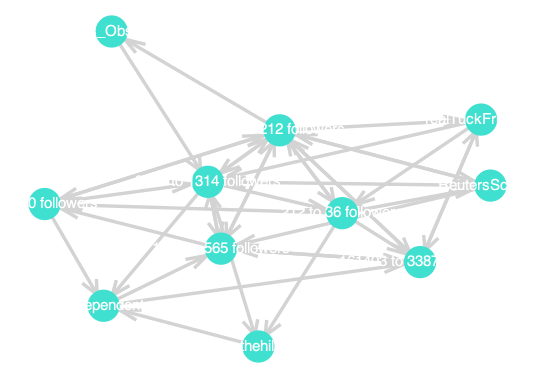

In [12]:
begin
	function make_simplifier(edge_type)
		if edge_type=="Any Edge"
			return x->(maximum(x)>cuttoff)
		else
			idx = findfirst(x->(x==et), edgeTypes)
			return x->(x[idx]>cuttoff)
		end
	end

	et = "Any Edge"
	s = make_simplifier(et)

	cuttoff = 0.5
	icg = InfluenceCascadeGenerator(cuttoff)
	influence_cascades = observe.(influence_graph, Ref(icg))

	
	partitions = unique(df[!,tsg.part_col])
	part = "neutral"
	i = (1:length(partitions))[findfirst(x->x==part, partitions)]
	
	# In this case we plot the graph on a world map
	if actor_fun == country
		PlotlyJS.plot(map_plot(df)...)
	# In this case we plot a simple graph of the actors
	else
		#gplot(g, xs, ys, nodelabel=unique(df.actor))
		plot_graph(influence_graph[i], df, simplifier=s)
	end
	
end

In [13]:
partition_index = (1:length(partitions))[findfirst(part .== partitions)]
influencer_indices = [ic.root for ic in influence_cascades[partition_index]]
influencers = unique(df.actor)[influencer_indices]

6-element Vector{String}:
 "DerekCressman"
 "tveitdal"
 "grist"
 "ClimateReality"
 "ScienceNews"
 "CBCNews"

In [14]:
#=
infl = unique(df.actor)[influencers]
influencer_node1 = infl[1]
influencer_node2 = infl[1]

PlotlyJS.plot(plot_cascade_sankey(
	influence_cascades[findfirst(x->x==part,unique(df[!, tsg.part_col]))][findfirst(x->x==influencer_node1, unique(df[!, tsg.actor_col])[influencers])],
	unique(df[!, tsg.action_col]))...)
=#

LoadError: ArgumentError: unable to check bounds for indices of type String

In [ ]:
#PlotlyJS.savefig(PlotlyJS.plot(plot_cascade_sankey(
#	influence_cascades[2][4], unique(df[!, tsg.action_col]))...), "sankey.png")

In [15]:
PlotlyJS.plot(plot_cascade_sankey(
influence_cascades[2][3], unique(df[!, tsg.action_col]))...)

LoadError: MethodError: no method matching plot_cascade_sankey(::InfluenceCascade, ::Vector{String})
[0mClosest candidates are:
[0m  plot_cascade_sankey(::InfluenceCascade, [91m::DataFrame[39m) at ~/Desktop/Thesis/Julia/Sensors/InfluenceCascadeGenerator/InfluenceCascadeGenerator.jl:140

PyPlot.Figure(PyObject <Figure size 800x800 with 3 Axes>)

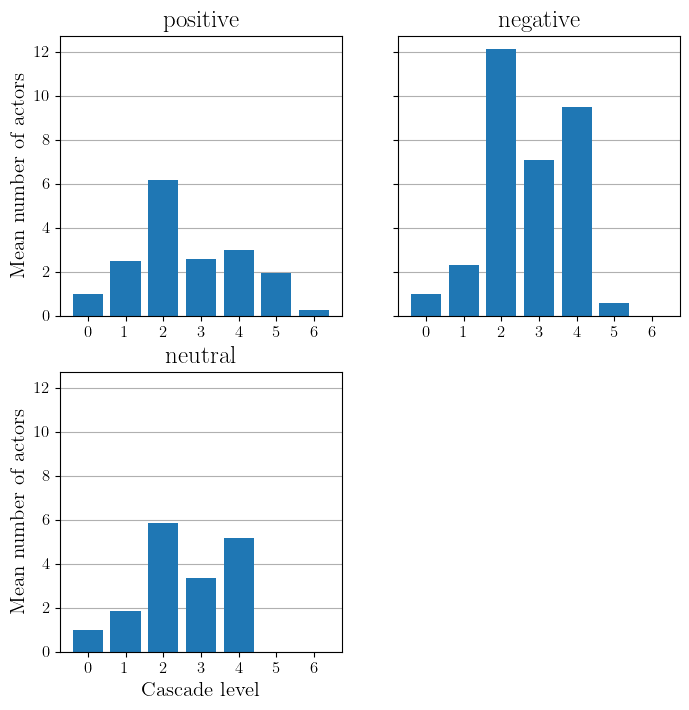

In [16]:
show(plot_actors_per_level(influence_cascades, df))

In [17]:
plot_actor_wordcloud(df, Nactor=300)

LoadError: InterruptException:

PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

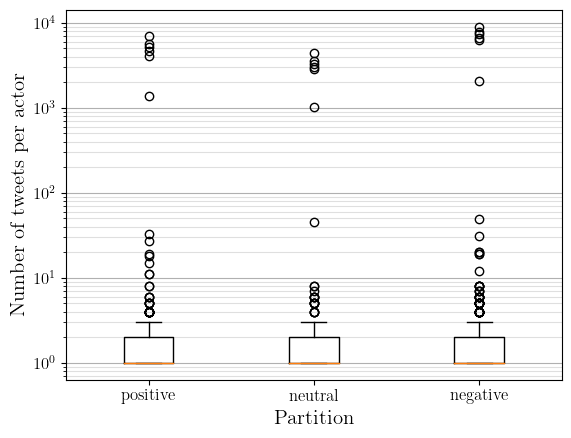

In [18]:
show(plot_actor_frequency(df))

PyPlot.Figure(PyObject <Figure size 800x800 with 3 Axes>)

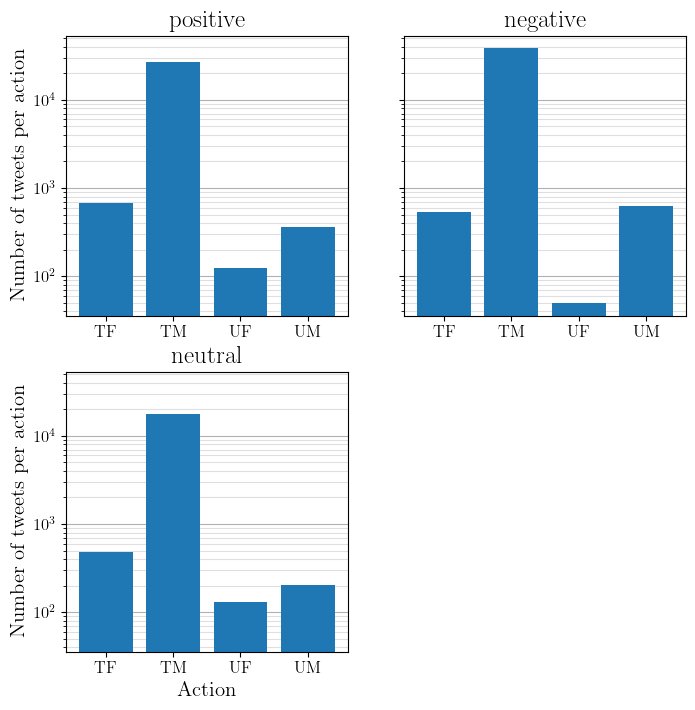

In [19]:
show(plot_action_frequency(df, split_by_partition = true))

In [20]:
show(plot_action_frequency_v2(df, split_by_partition = true))

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/cyrilvallez/.julia/packages/PyCall/ygXW2/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (4,).')
  File "/Users/cyrilvallez/.julia/conda/3/lib/python3.10/site-packages/matplotlib/pyplot.py", line 2355, in bar
    return gca().bar(
  File "/Users/cyrilvallez/.julia/conda/3/lib/python3.10/site-packages/matplotlib/__init__.py", line 1423, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/cyrilvallez/.julia/conda/3/lib/python3.10/site-packages/matplotlib/axes/_axes.py", line 2383, in bar
    x, height, width, y, linewidth, hatch = np.broadcast_arrays(
  File "<__array_function__ internals>", line 180, in broadcast_arrays
  File "/Users/cyrilvallez/.julia/conda/3/lib/python3.10/site-packages/numpy/lib/stride_tricks.py", line 540, in broadcast_arrays
    shape = _broadcast_shape(*args)
  File "/Users/cyrilvallez/.julia/conda/3/lib/python3.10/site-packages/numpy/lib/stride_tricks.py", line 422, in _broadcast_shape
    b = np.broadcast(*args[:32])
